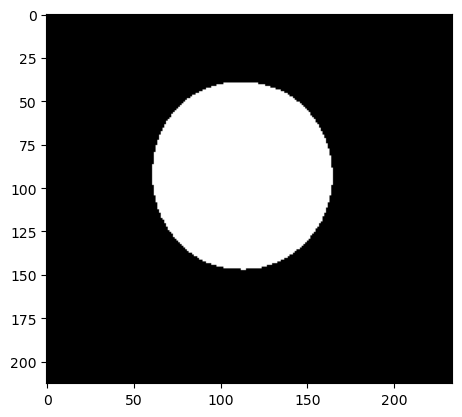

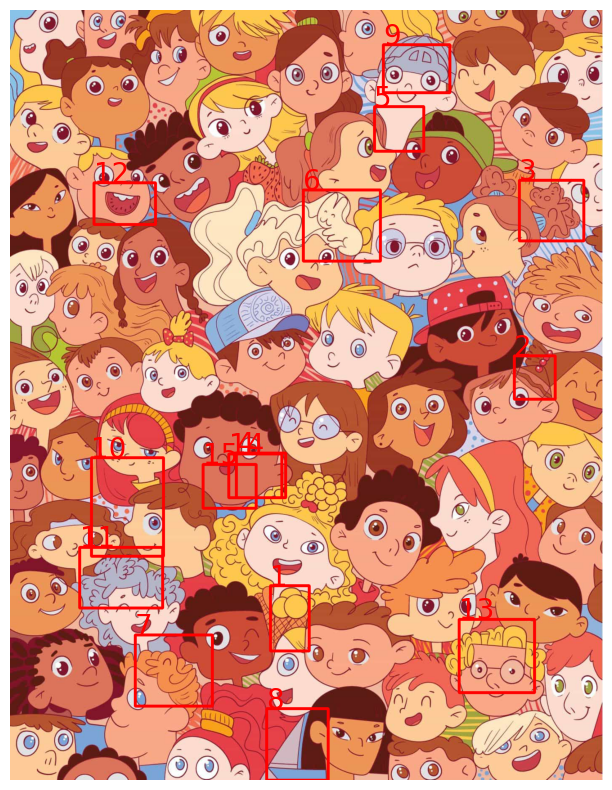

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

image = cv2.imread("left_part.jpg")
plt.imshow(image[:, :, ::-1])  # Chuyển màu từ BGR sang RGB để hiển thị đúng
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

object_list = os.listdir("image/Split")
object_list = [os.path.join("image/Split", obj) for obj in object_list if obj.endswith('.jpg')]  # Chỉ lấy .jpg

# Hàm lấy các template
def get_template(folder_path: str):
    templates = []
    for file in os.listdir(folder_path):
        if file.endswith('.jpg'):  # Lọc .jpg
            template = cv2.imread(os.path.join(folder_path, file))
            templates.append(template)
    return templates

# Tải các template
templates = get_template('image/Split')


# Hàm tạo mask cho template
def create_mask(template):
    gray_template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray_template, 200, 255, cv2.THRESH_BINARY_INV)
    return mask

# Tạo mask cho template thứ 4
mask = create_mask(cv2.imread(object_list[3]))
plt.imshow(mask, cmap="gray")

# Các tỉ lệ để resize template (50% -> 100%)
scales = np.linspace(0.5, 1, 10)
res_points = [] 
output_image = image.copy()

# Quá trình khớp template với ảnh chính
for object_path in object_list:
    template = cv2.imread(object_path)  # Đọc template (tất cả là .jpg)

    mask = create_mask(template)

    # Khởi tạo điểm số tối ưu để tìm max_val của mỗi template
    max_val_global = -1
    best_match_loc = None
    best_scale = None
    best_w, best_h = None, None

    # Khớp template với ảnh chính qua các tỉ lệ khác nhau
    for scale in scales:
        resized_template = cv2.resize(template, (0, 0), fx=scale, fy=scale)
        resized_mask = cv2.resize(mask, (resized_template.shape[1], resized_template.shape[0]))

        w, h = resized_template.shape[1], resized_template.shape[0]

        # Khớp template với ảnh chính
        result = cv2.matchTemplate(image, resized_template, cv2.TM_CCOEFF_NORMED, mask=resized_mask)

        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

        if max_val > max_val_global:
            max_val_global = max_val
            best_match_loc = max_loc
            best_scale = scale
            best_w, best_h = w, h

    # Nếu tìm thấy vị trí khớp tốt nhất, vẽ hình chữ nhật quanh khu vực khớp
    if best_match_loc is not None:
        top_left = best_match_loc
        bottom_right = (top_left[0] + best_w, top_left[1] + best_h)
        cv2.rectangle(output_image, top_left, bottom_right, (0, 0, 255), 5)
        res_points.append(top_left)

# Hiển thị kết quả
plt.figure(figsize=(10, 10))
for idx in range(len(res_points)):
    plt.annotate(str(idx + 1), res_points[idx], color="red", fontsize=20)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))  # Chuyển màu từ BGR sang RGB để hiển thị đúng
plt.axis('off')

# Lưu kết quả vào file
cv2.imwrite("output_image.jpg", output_image)

# Hiển thị ảnh
plt.show()
